#Imports

In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.0 MB/s eta 0:00:00


In [2]:
# !pip install torch --upgrade
# !pip install torchvision==0.12.0

In [3]:
#basic
from pathlib import Path
import random
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
# import PIL
from PIL import Image

#modeling
from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import timm
from torch.nn import functional as F
import torch.optim as optim
import copy

%matplotlib inline

#Data loading

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

100% 1.62G/1.62G [01:17<00:00, 25.8MB/s]
100% 1.62G/1.62G [01:17<00:00, 22.5MB/s]


In [6]:
!unzip /content/ocular-disease-recognition-odir5k.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg

In [7]:
df_all = pd.read_csv('/content/full_df.csv')

In [8]:
df_all.sample(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
1389,2116,81,Female,2116_left.jpg,2116_right.jpg,cataract,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",2116_right.jpg
2223,3103,78,Male,3103_left.jpg,3103_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3103_right.jpg
5632,3340,53,Female,3340_left.jpg,3340_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3340_left.jpg
4653,2193,50,Female,2193_left.jpg,2193_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",2193_left.jpg
3095,4568,54,Male,4568_left.jpg,4568_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4568_right.jpg


In [9]:
df_all[df_all['ID']==2244]

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
1505,2244,76,Male,2244_left.jpg,2244_right.jpg,lens dust，cataract,cataract，lens dust,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",2244_right.jpg


In [10]:
df_all['left_cataract'] = df_all['Left-Diagnostic Keywords'].apply(lambda x: 1 if 'cataract' in str(x).lower() else 0)
df_all['right_cataract'] = df_all['Right-Diagnostic Keywords'].apply(lambda x: 1 if 'cataract' in str(x).lower() else 0)

In [11]:
left_cataract = df_all[df_all['left_cataract'] == 1]['Left-Fundus'].values
right_cataract = df_all[df_all['right_cataract'] == 1]['Right-Fundus'].values
print(f'Number of images in left cataract: {len(left_cataract)}')
print(f'Number of images in right cataract: {len(right_cataract)}')

Number of images in left cataract: 304
Number of images in right cataract: 290


In [12]:
left_normal = df_all[(df_all['C']==0) & (df_all['Left-Diagnostic Keywords']=='normal fundus')]['Left-Fundus'].values
right_normal = df_all[(df_all['C']==0) & (df_all['Right-Diagnostic Keywords']=='normal fundus')]['Right-Fundus'].values
print(f'Number of images in left normal: {len(left_normal)}')
print(f'Number of images in right normal: {len(right_normal)}')

Number of images in left normal: 2748
Number of images in right normal: 2657


In [13]:
cataract = np.concatenate([left_cataract, right_cataract])
normal = np.concatenate([left_normal, right_normal])

In [14]:
cataract = pd.DataFrame(cataract, columns=['filename'])
normal = pd.DataFrame(normal, columns=['filename'])

In [15]:
cataract['label'] = 1
normal['label'] = 0

In [16]:
df_combined = pd.concat([cataract, normal])
df_combined.sample(10)

,filename,label
5287,3415_right.jpg,0
1521,834_left.jpg,0
1454,467_left.jpg,0
2813,351_right.jpg,0
1822,2554_left.jpg,0
2225,3005_left.jpg,0
2587,3409_left.jpg,0
722,2895_left.jpg,0
1403,259_left.jpg,0
1260,4218_left.jpg,0


##Data review

In [17]:
root_path = Path('/content/preprocessed_images')

In [18]:
def rand_image():
  idx = random.randint(0, len(df_combined))
  filename = df_combined.filename.iloc[idx]
  image = root_path/filename
  label = df_combined.label.iloc[idx]
  return image, label

In [19]:
# fig, axs = plt.subplots(3, 5, figsize=(15,7))
# axs = axs.flatten()

# for ax in axs:
#   img, label = rand_image()
#   img = Image.open(img)
#   ax.imshow(img)
#   ax.axis('off')
#   ax.set_title(f'Cataract: {label}')

##Sample tranformations

In [20]:
list_transforms = [transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                 transforms.RandomEqualize(),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.Grayscale(),
                                 transforms.RandomInvert()]

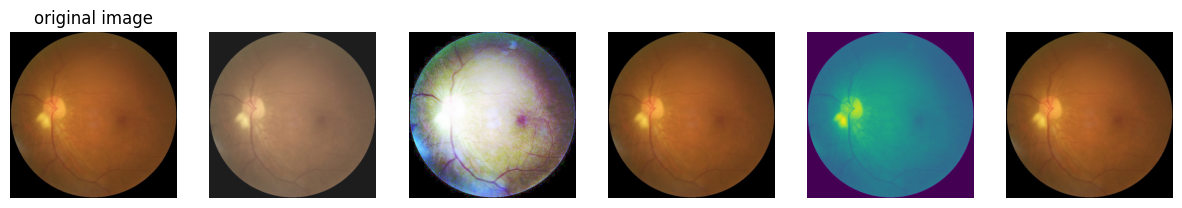

In [21]:
fig, axs = plt.subplots(1,6, figsize=(15,3))
axs = axs.flatten()
img, label = rand_image()
img = Image.open(img)


for i, ax in enumerate(axs):
  axs[0].imshow(img)
  axs[0].set_title('original image')
  transf = list_transforms[i-1]
  ax = axs[i]
  ax.axis('off')
  transf_img = transf(img)
  ax.imshow(transf_img)

#Split to train, validation and test sets

In [22]:
X = df_combined.copy()
y = df_combined['label']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=6)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=6)

In [24]:
path_dict = {'train/': X_train, 'val/': X_val, 'test/': X_test}

for key, df in path_dict.items():

  save_path = Path(key)

  for i, img in enumerate(tqdm(df.filename)):
    img_path = root_path/img

    label = df.label.iloc[i]

    img_save_path = root_path/save_path/str(label)
    img_save_path.mkdir(parents=True, exist_ok=True)

    if img_path.exists():
      shutil.copy(img_path, img_save_path)

100%|██████████| 1200/1200 [00:00<00:00, 3314.79it/s]


#Create Pytorch Data Generators

In [25]:
train_path = '/content/preprocessed_images/train'
val_path = '/content/preprocessed_images/val'
test_path = '/content/preprocessed_images/test'

In [26]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Train_dataloader will be create later

val_transforms = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     normalize])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     normalize])

In [27]:
val_dataset = datasets.ImageFolder(val_path, val_transforms)
test_dataset = datasets.ImageFolder(test_path,test_transforms)

In [28]:
batch_size = 32
num_workers = 2

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [29]:
def create_dataloaders(transform, batch_size, val_loader):
  data_tranforms = transforms.Compose([transform,
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       normalize])

  trying_dataset = datasets.ImageFolder(train_path, data_tranforms)
  trying_loader = torch.utils.data.DataLoader(trying_dataset,
                                              batch_size = batch_size,
                                              shuffle=True,
                                              num_workers=2)

  dataloaders = {'train': trying_loader, 'val': val_loader}

  return dataloaders

#Model function

In [30]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)

cuda


In [31]:
# # Load the EfficientNet architecture
# model_b0_1 = timm.create_model('efficientnet_b0', pretrained=True)

# for param in model_b0_1.parameters():
#     param.requires_grad = False

# # Replace the last classification layer with a new layer with two outputs
# num_ftrs = model_b0_1.classifier.in_features
# model_b0_1.classifier = nn.Linear(num_ftrs, 2)

# # Add a softmax function at the end
# model_b0_1 = nn.Sequential(model_b0_1, nn.Softmax(dim=1))

# model_b0_1 = model_b0_1.to(device)

In [32]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model_b0_1.parameters(), lr=0.001)

In [33]:
criterion = nn.CrossEntropyLoss()

In [44]:
def prepare_model_1(pre_trained_model, class_function=nn.Sigmoid(), learning_rate=0.001):

  # Load the EfficientNet architecture
  model = timm.create_model(pre_trained_model, pretrained=True)

  for param in model.parameters():
    param.requires_grad = False

  # Replace the last classification layer with a new layer with two outputs
  num_ftrs = model.classifier.in_features
  model.classifier = nn.Linear(num_ftrs, 2)

  # Add a function at the end
  model = nn.Sequential(model, class_function)

  model = model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  return model, optimizer

In [45]:
def prepare_model_2(pre_trained_model, class_function=nn.Sigmoid(), learning_rate=0.001):

  model = timm.create_model(pre_trained_model, pretrained=True)

  for param in model.parameters():
    param.requires_grad = False

  num_ftrs = model.classifier.in_features
  model.classifier = nn.Sequential(nn.Linear(num_ftrs, 256),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(256),
                                   nn.Dropout(0.5),
                                   nn.Linear(256, 2))

  model = nn.Sequential(model, class_function)

  model = model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  return model, optimizer

In [ ]:
efficientnet_models = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5']

In [ ]:
# # Load the EfficientNet architecture
# efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)

# # Replace the last classification layer with a new layer with two outputs
# num_ftrs = efficientnet_model.classifier.in_features
# efficientnet_model.classifier = nn.Sequential(
#     nn.Linear(num_ftrs, 256),  # Dodaj dodatkową warstwę
#     nn.ReLU(),  # Funkcja aktywacji
#     nn.BatchNorm1d(256),  # Batch Normalization
#     nn.Dropout(0.5),  # Dropout dla regularyzacji
#     nn.Linear(256, 2)  # Warstwa klasyfikacyjna z dwoma wyjściami (2 klasy)
# )

# # Dodaj funkcję softmax na końcu
# efficientnet_model = nn.Sequential(
#     efficientnet_model,
#     nn.Softmax(dim=1)
# )

# # Wydrukuj zaktualizowaną architekturę
# print(efficientnet_model)

In [ ]:
# model = models.resnet101(pretrained=True).to(device)

# for param in model.parameters():
#     param.requires_grad = False

# model.fc = nn.Sequential(
#                nn.Linear(2048, 128),
#                nn.ReLU(inplace=True),
#                nn.Linear(128, 2)).to(device)

#Train and test model function

In [37]:
def calculate_f1(precision, recall):
  F1 = 2 * precision * recall / (precision + recall)
  return F1

In [92]:
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=10):

    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    best_val_loss = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        metrics = {}

        for phase in ['train', 'val']:
          if phase == 'train':
              model.train()
          else:
              model.eval()

          running_loss = 0.0
          corrects = 0
          r_positives = 0
          t_positives = 0
          tf_positives = 0

          for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if phase == 'train':
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()


            metrics[phase] = {}
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            corrects += sum(preds == labels.data)
            r_positives += sum(labels == 1).item()
            t_positives += sum((preds == labels) & (labels == 1)).item()
            tf_positives += sum(preds == 1).item()

        if phase == 'train':
          scheduler.step()

        num_inputs = len(dataloaders[phase].dataset)
        metrics[phase]['loss'] = round(running_loss / num_inputs, 4)
        metrics[phase]['acc'] = round(corrects.item() / num_inputs, 4)
        metrics[phase]['precision'] = round(t_positives / tf_positives, 4)
        metrics[phase]['recall'] = round(t_positives / r_positives, 4)
        metrics[phase]['F1'] = round(calculate_f1(metrics[phase]['precision'], metrics[phase]['recall']), 4)

        print(f'{phase} loss: {metrics[phase]["loss"]:.4f}, {phase} accuracy: {metrics[phase]["acc"]:.4f}')

        if metrics['val']['loss'] >= best_val_loss:
          best_val_loss = metrics['val']['loss']
          best_metrics = pd.DataFrame(metrics)
          best_model = model

        train_loss_history.append(metrics['train']['loss'])
        train_accuracy_history.append(metrics['train']['acc'])
        val_loss_history.append(metrics['val']['loss'])
        val_accuracy_history.append(metrics['val']['acc'])

        train_history = [train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history]

    return best_model, best_metrics, train_history

In [ ]:
# if val_roc >= best_val:
#                 best_val = val_roc
#                 patience = es_patience  # Resetting patience since we have new best validation accuracy
#                 torch.save(model, model_path)  # Saving current best model
#             else:
#                 patience -= 1
#                 if patience == 0:
#                     print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
#                     break

In [ ]:
# num_epochs = 10
# model = model_b0_1
# dataloaders = {'train': train_loader, 'val': val_loader}

In [ ]:
# train_loss_history = []
# train_accuracy_history = []
# val_loss_history = []
# val_accuracy_history = []
# best_train_accuracy = 0
# best_val_accuracy = 0

# for epoch in range(num_epochs):
#     print(f'Epoch {epoch+1}/{num_epochs}')

#     metrics = {}

#     for phase in ['train', 'val']:
#         if phase == 'train':
#             model.train()
#         else:
#             model.eval()

#         running_loss = 0.0
#         corrects = 0
#         r_positives = 0
#         t_positives = 0
#         tf_positives = 0

#         for inputs, labels in dataloaders[phase]:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)

#             if phase == 'train':
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#             metrics[phase] = {}
#             _, preds = torch.max(outputs, 1)
#             running_loss += loss.item() * inputs.size(0)
#             corrects += sum(preds == labels.data).item()
#             r_positives += sum(labels == 1).item()
#             t_positives += sum((preds == labels) & (labels == 1)).item()
#             tf_positives += sum(preds == 1).item()

#         num_inputs = len(dataloaders[phase].dataset)
#         metrics[phase]['loss'] = round(running_loss / num_inputs, 4)
#         metrics[phase]['acc'] = round(corrects / num_inputs, 4)
#         metrics[phase]['precision'] = round(t_positives / tf_positives, 4)
#         metrics[phase]['recall'] = round(t_positives / r_positives, 4)
#         metrics[phase]['F1'] = round(calculate_f1(metrics[phase]['precision'], metrics[phase]['recall']), 4)


#         print(f'{phase} loss: {metrics[phase]["loss"]:.4f}, {phase} accuracy: {metrics[phase]["acc"]:.4f}')

#     if (metrics['val']['acc'] >= best_val_accuracy): # and (metrics['train']['acc'] >= best_train_accuracy):
#       best_val_accuracy = metrics['val']['acc']
#       best_train_accuracy = metrics['train']['acc']
#       best_metrics = pd.DataFrame(metrics)
#       best_model = model

#     train_loss_history.append(metrics['train']['loss'])
#     train_accuracy_history.append(metrics['train']['acc'])
#     val_loss_history.append(metrics['val']['loss'])
#     val_accuracy_history.append(metrics['val']['acc'])

#     train_history = [train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history]

In [ ]:
def test_model(dataloader, model, criterion):

  running_loss = 0.0
  running_corrects = 0

  model.eval()

  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += sum(preds == labels.data)

    num_inputs = len(dataloader.dataset)
    test_loss = running_loss / num_inputs
    test_accuracy = running_corrects.item() / num_inputs

  return test_loss, test_accuracy

In [ ]:
def plot_learning(train_history):
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))
  history = {'Accuracy': [train_history[0], train_history[1]], 'Loss': [train_history[2], train_history[3]]}

  for i, name in enumerate(['Accuracy', 'Loss']):
    ax = axs[i]
    ax.plot(history[name][0], label='train')
    ax.plot(history[name][1], label='validation')
    ax.set_title(name)
    ax.legend()
    ax.set_xlabel('no. of epochs')
  plt.show()

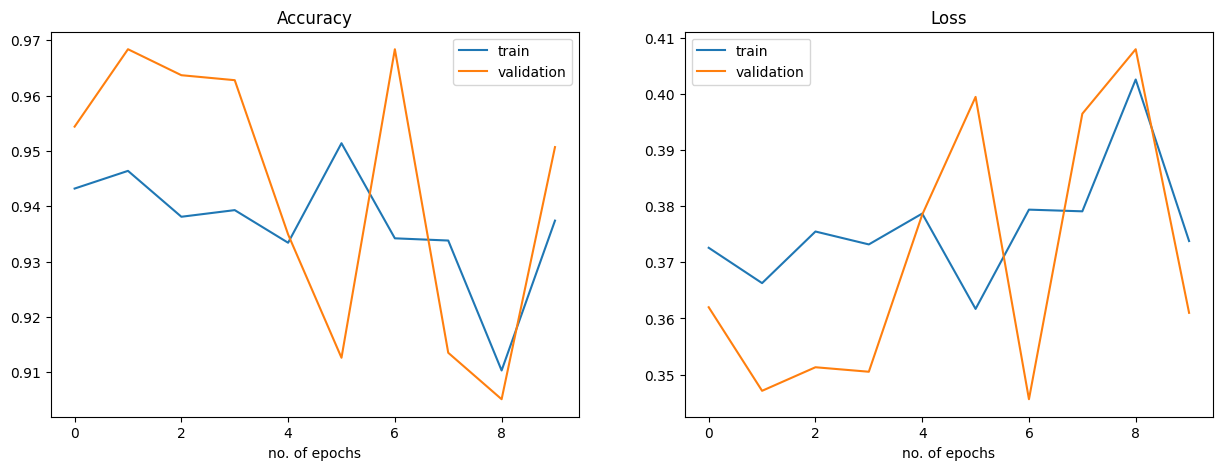

In [ ]:
plot_learning(train_history)

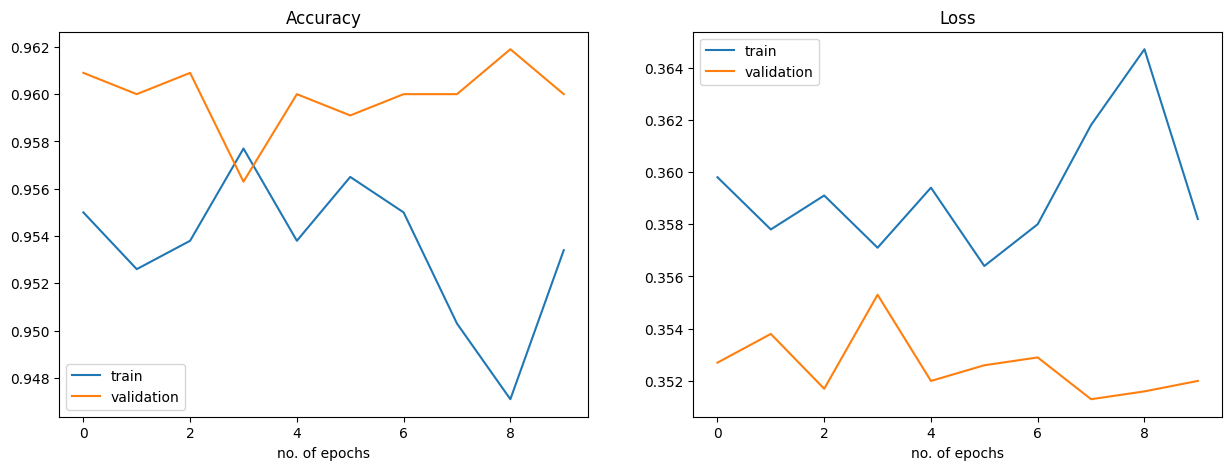

In [ ]:
plot_learning(train_history)

#Selecting

##Selecting transformations

In [97]:
model, optimizer = prepare_model_1('efficientnet_b0')

In [48]:
transformations = {'ColorJitter': transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                   'RandomSharpness_08': transforms.RandomAdjustSharpness(sharpness_factor=0.8),
                   'RandomEqualize': transforms.RandomEqualize(),
                   'GaussianBlur_1': transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.5,2)),
                   'RandomHorizontalFlip': transforms.RandomHorizontalFlip(),
                   'RandomAffine': transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.95, 1.05)),
                   'RandomSharpness_11': transforms.RandomAdjustSharpness(sharpness_factor=1.1),
                   'RandomInvert': transforms.RandomInvert(),
                   'RandomAutocontrast': transforms.RandomAutocontrast(),
                   'RandomGrayscale': transforms.RandomGrayscale(p=0.5),
                   'GaussianBlur_2': transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1,1)),
                   'RandomVerticalFlip': transforms.RandomVerticalFlip(),
                   'RandomRotation': transforms.RandomRotation(degrees=(-5, 5)),
                   'RandomCrop': transforms.RandomCrop(size=(200, 200)),
                   'RandomSharpness_12': transforms.RandomAdjustSharpness(sharpness_factor=1.2)}

In [51]:
i = 0
transformations_scores = pd.DataFrame({'transformations': transformations.keys(),
                                       'loss': np.zeros(len(transformations)),
                                       'accuracy': np.zeros(len(transformations)),
                                       'precision': np.zeros(len(transformations)),
                                       'recall': np.zeros(len(transformations)),
                                       'F1': np.zeros(len(transformations))})

for key, transform in transformations.items():
  print(key)
  dataloaders = create_dataloaders(transform, batch_size, val_loader)
  trained_model, metrics, history = train_model(dataloaders, model, criterion, optimizer, num_epochs=5)
  print()

  for j in list(range(1,6)):
    transformations_scores.iloc[i,j] = metrics.iloc[j-1,1]

  i+=1

ColorJitter
Epoch 1/5
train loss: 0.3401, train accuracy: 0.9738
val loss: 0.3318, val accuracy: 0.9860
Epoch 2/5
train loss: 0.3389, train accuracy: 0.9777
val loss: 0.3330, val accuracy: 0.9805
Epoch 3/5
train loss: 0.3374, train accuracy: 0.9785
val loss: 0.3311, val accuracy: 0.9870
Epoch 4/5
train loss: 0.3371, train accuracy: 0.9769
val loss: 0.3314, val accuracy: 0.9842
Epoch 5/5
train loss: 0.3365, train accuracy: 0.9792
val loss: 0.3305, val accuracy: 0.9860

RandomSharpness_08
Epoch 1/5
train loss: 0.3322, train accuracy: 0.9832
val loss: 0.3325, val accuracy: 0.9833
Epoch 2/5
train loss: 0.3306, train accuracy: 0.9847
val loss: 0.3307, val accuracy: 0.9870
Epoch 3/5
train loss: 0.3319, train accuracy: 0.9836
val loss: 0.3314, val accuracy: 0.9842
Epoch 4/5
train loss: 0.3308, train accuracy: 0.9851
val loss: 0.3301, val accuracy: 0.9870
Epoch 5/5
train loss: 0.3304, train accuracy: 0.9855
val loss: 0.3306, val accuracy: 0.9842

RandomEqualize
Epoch 1/5
train loss: 0.3400, tr

In [ ]:
transformations_scores

In [ ]:
transformations = {'RandomHorizontalFlip': transforms.RandomHorizontalFlip(),
                   'RandomAffine': transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.95, 1.05)),
                   'RandomSharpness_11': transforms.RandomAdjustSharpness(sharpness_factor=1.1),
                   'RandomInvert': transforms.RandomInvert(),
                   'RandomAutocontrast': transforms.RandomAutocontrast(),
                   'GaussianBlur_2': transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1,1)),
                   'RandomVerticalFlip': transforms.RandomVerticalFlip(),
                   'RandomRotation': transforms.RandomRotation(degrees=(-5, 5)),
                   'RandomSharpness_12': transforms.RandomAdjustSharpness(sharpness_factor=1.2)}

In [ ]:
valid_scores

,transformations,accuracy,precision,recall,F1
0,ColorJitter,0.9786,0.9082,0.8641,0.8856
1,RandomEqualize,0.9842,0.9574,0.8738,0.9137
2,RandomInvert,0.9842,0.9479,0.8835,0.9146
3,RandomAutocontrast,0.9860,0.9583,0.8932,0.9246
4,RandomGrayscale,0.9823,0.9286,0.8835,0.9055
5,RandomHorizontalFlip,0.9888,0.9505,0.9320,0.9412
6,RandomRotation,0.9879,0.9500,0.9223,0.9359
7,RandomCrop,0.9563,0.7545,0.8058,0.7793


In [ ]:
valid_scores

,transformations,accuracy,precision,recall,F1
0,ColorJitter,0.9740,0.9121,0.8058,0.8557
1,RandomEqualize,0.9758,0.8812,0.8641,0.8726
2,RandomAffine,0.9767,0.8824,0.8738,0.8781
3,RandomInvert,0.9767,0.8679,0.8932,0.8804
4,RandomAutocontrast,0.9814,0.9192,0.8835,0.9010
5,RandomGrayscale,0.9767,0.8900,0.8641,0.8769
6,RandomHorizontalFlip,0.9814,0.9109,0.8932,0.9020
7,RandomVerticalFlip,0.9870,0.9684,0.8932,0.9293
8,RandomRotation,0.9898,0.9600,0.9320,0.9458
9,RandomCrop,0.9498,0.6842,0.8835,0.7712


In [54]:
selected_transforms = transforms.RandomChoice([transforms.RandomHorizontalFlip(),
                                               transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.95, 1.05)),
                                               transforms.RandomAdjustSharpness(sharpness_factor=1.1),
                                               transforms.RandomInvert(),
                                               transforms.RandomAutocontrast(),
                                               transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1,1)),
                                               transforms.RandomVerticalFlip(),
                                               transforms.RandomRotation(degrees=(-5, 5)),
                                               transforms.RandomAdjustSharpness(sharpness_factor=1.2)])

## Selecting train batch size

In [55]:
batch_size_list = [2, 4, 16, 32, 64, 128]

In [63]:
batch_scores = pd.DataFrame({'batch_size': batch_size_list,
                             'loss': np.zeros(len(batch_size_list)),
                             'accuracy': np.zeros(len(batch_size_list)),
                             'precision': np.zeros(len(batch_size_list)),
                             'recall': np.zeros(len(batch_size_list)),
                             'F1': np.zeros(len(batch_size_list))})

for i, batch_size in enumerate(batch_size_list):
  print(f'Batch_size: {batch_size}')
  dataloaders = create_dataloaders(selected_transforms, batch_size, val_loader)
  trained_model, metrics, history = train_model(dataloaders, model, criterion, optimizer, num_epochs=5)
  print()

  for j in list(range(1,6)):
    batch_scores.iloc[i,j] = metrics.iloc[j-1,1]

Batch_size: 2
Epoch 1/5
train loss: 0.3483, train accuracy: 0.9652
val loss: 0.3818, val accuracy: 0.9312
Epoch 2/5
train loss: 0.3453, train accuracy: 0.9691
val loss: 0.3882, val accuracy: 0.9200
Epoch 3/5
train loss: 0.3496, train accuracy: 0.9632
val loss: 0.4092, val accuracy: 0.9005
Epoch 4/5
train loss: 0.3514, train accuracy: 0.9605
val loss: 0.4211, val accuracy: 0.8865
Epoch 5/5
train loss: 0.3462, train accuracy: 0.9675
val loss: 0.4607, val accuracy: 0.8409

Batch_size: 4
Epoch 1/5
train loss: 0.3455, train accuracy: 0.9667
val loss: 0.3574, val accuracy: 0.9553
Epoch 2/5
train loss: 0.3424, train accuracy: 0.9706
val loss: 0.3558, val accuracy: 0.9563
Epoch 3/5
train loss: 0.3386, train accuracy: 0.9738
val loss: 0.3591, val accuracy: 0.9544
Epoch 4/5
train loss: 0.3427, train accuracy: 0.9695
val loss: 0.3377, val accuracy: 0.9777
Epoch 5/5
train loss: 0.3398, train accuracy: 0.9730
val loss: 0.3550, val accuracy: 0.9563

Batch_size: 16
Epoch 1/5
train loss: 0.3344, train

In [62]:
batch_scores

,batch_size,loss,accuracy,precision,recall,F1
0,2,0.5584,0.7349,0.2618,0.9709,0.4124
1,4,0.3692,0.9451,0.6429,0.9612,0.7705
2,16,0.3321,0.9842,0.8909,0.9515,0.9202
3,32,0.3274,0.9870,0.9238,0.9417,0.9327
4,64,0.3266,0.9888,0.9417,0.9417,0.9417
5,128,0.3257,0.9879,0.9500,0.9223,0.9359


In [64]:
batch_scores

,batch_size,loss,accuracy,precision,recall,F1
0,2,0.4607,0.8409,0.3731,0.9709,0.5391
1,4,0.3591,0.9544,0.6875,0.9612,0.8016
2,16,0.3320,0.9823,0.8818,0.9417,0.9108
3,32,0.3274,0.9870,0.9159,0.9515,0.9334
4,64,0.3258,0.9888,0.9417,0.9417,0.9417
5,128,0.3252,0.9879,0.9327,0.9417,0.9372


In [65]:
train_batch_size = 64

##Selecting learning rate sheduler

In [74]:
from torch.optim.lr_scheduler import LambdaLR
lr_lambda = lambda epoch: 0.001

# Tworzenie scheduler'a
lr_scheduler = LambdaLR(optimizer, lr_lambda)

In [94]:
from torch.optim.lr_scheduler import StepLR

st_scheduler = StepLR(optimizer,
                   step_size = 10, # Period of learning rate decay
                   gamma = 1)

In [66]:
from torch.optim.lr_scheduler import ExponentialLR

exp_scheduler = ExponentialLR(optimizer,
                          gamma = 0.7) # Multiplicative factor of learning rate decay.

In [68]:
from torch.optim.lr_scheduler import CosineAnnealingLR

cos_scheduler = CosineAnnealingLR(optimizer,
                              T_max = 32, # Maximum number of iterations.
                             eta_min = 1e-4) # Minimum learning rate.

In [ ]:
# from torch.optim.lr_scheduler import CyclicLR

# cc_tr_scheduler = CyclicLR(optimizer,
#                      base_lr = 0.0001, # Initial learning rate which is the lower boundary in the cycle for each parameter group
#                      max_lr = 1e-3, # Upper learning rate boundaries in the cycle for each parameter group
#                      step_size_up = 4, # Number of training iterations in the increasing half of a cycle
#                      mode = "triangular")

# cc_tr2_scheduler = CyclicLR(optimizer,
#                      base_lr = 0.0001, # Initial learning rate which is the lower boundary in the cycle for each parameter group
#                      max_lr = 1e-3, # Upper learning rate boundaries in the cycle for each parameter group
#                      step_size_up = 4, # Number of training iterations in the increasing half of a cycle
#                      mode = "triangular2")

# cc_exp_scheduler = CyclicLR(optimizer,
#                      base_lr = 0.0001, # Initial learning rate which is the lower boundary in the cycle for each parameter group
#                      max_lr = 1e-3, # Upper learning rate boundaries in the cycle for each parameter group
#                      step_size_up = 4, # Number of training iterations in the increasing half of a cycle
#                      mmode = "exp_range")

In [82]:
from torch.optim.lr_scheduler import OneCycleLR


oc_cos_scheduler = OneCycleLR(optimizer,
                       max_lr = 1e-3, # Upper learning rate boundaries in the cycle for each parameter group
                       steps_per_epoch = 6, # The number of steps per epoch to train for.
                       epochs = 3, # The number of epochs to train for.
                       anneal_strategy = 'cos') # Specifies the annealing strategy

oc_lin_scheduler = OneCycleLR(optimizer,
                       max_lr = 1e-3, # Upper learning rate boundaries in the cycle for each parameter group
                       steps_per_epoch = 8, # The number of steps per epoch to train for.
                       epochs = 4, # The number of epochs to train for
                       anneal_strategy = "linear") # Specifies the annealing strategy

In [95]:
schedulers = {'st_scheduler': st_scheduler, 'exp_scheduler': exp_scheduler,
                  'cos_scheduler': cos_scheduler, 'oc_cos_scheduler': oc_cos_scheduler,
                  'oc_lin_scheduler': oc_lin_scheduler}

In [98]:
scheduler_scores = pd.DataFrame({'scheduler': schedulers.keys(),
                             'loss': np.zeros(len(schedulers)),
                             'accuracy': np.zeros(len(schedulers)),
                             'precision': np.zeros(len(schedulers)),
                             'recall': np.zeros(len(schedulers)),
                             'F1': np.zeros(len(schedulers))})
i=0
for key, scheduler in schedulers.items():
  print(f'scheduler: {key}')
  dataloaders = create_dataloaders(selected_transforms, train_batch_size, val_loader)
  trained_model, metrics, history = train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=10)
  print()

  for j in list(range(1,6)):
    scheduler_scores.iloc[i,j] = metrics.iloc[j-1,1]

  i+=1

scheduler: st_scheduler
Epoch 1/10
train loss: 0.4502, train accuracy: 0.8927
val loss: 0.3874, val accuracy: 0.9302
Epoch 2/10
train loss: 0.3800, train accuracy: 0.9397
val loss: 0.3662, val accuracy: 0.9563
Epoch 3/10
train loss: 0.3666, train accuracy: 0.9577
val loss: 0.3574, val accuracy: 0.9684
Epoch 4/10
train loss: 0.3597, train accuracy: 0.9628
val loss: 0.3531, val accuracy: 0.9702
Epoch 5/10
train loss: 0.3558, train accuracy: 0.9636
val loss: 0.3499, val accuracy: 0.9712
Epoch 6/10
train loss: 0.3535, train accuracy: 0.9663
val loss: 0.3479, val accuracy: 0.9740
Epoch 7/10
train loss: 0.3507, train accuracy: 0.9699
val loss: 0.3460, val accuracy: 0.9758
Epoch 8/10
train loss: 0.3494, train accuracy: 0.9683
val loss: 0.3455, val accuracy: 0.9749
Epoch 9/10
train loss: 0.3485, train accuracy: 0.9687
val loss: 0.3446, val accuracy: 0.9758
Epoch 10/10
train loss: 0.3466, train accuracy: 0.9702
val loss: 0.3436, val accuracy: 0.9749

scheduler: exp_scheduler
Epoch 1/10
train lo

In [99]:
scheduler_scores

,scheduler,loss,accuracy,precision,recall,F1
0,st_scheduler,0.3332,0.9814,0.9278,0.8738,0.9
1,exp_scheduler,0.0000,0.0000,0.0000,0.0000,0.0
2,cos_scheduler,0.0000,0.0000,0.0000,0.0000,0.0
3,oc_cos_scheduler,0.0000,0.0000,0.0000,0.0000,0.0
4,oc_lin_scheduler,0.0000,0.0000,0.0000,0.0000,0.0


In [100]:
metrics

,train,val
loss,0.3357,0.3332
acc,0.9792,0.9814
precision,0.9339,0.9278
recall,0.8480,0.8738
F1,0.8889,0.9000


##Training model

###Few_transformations

In [ ]:
few_transformations = [transforms.RandomInvert(),
                       transforms.RandomAutocontrast(),
                       transforms.RandomEqualize()]

In [ ]:
dataloaders_few = create_dataloaders(*few_transformations)

In [ ]:
model_trained_few, metrics_few, history_few = train_model(dataloaders_few,
                                                          model,
                                                          criterion,
                                                          optimizer,
                                                          num_epochs=600)

plot_learning(history_few)

print(f'\n The best results for few_transformations:')
metrics_few

In [ ]:
torch.save(model_trained_few.state_dict(),'/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_few.pt')

##Evaluate

In [ ]:
outcomes = pd.concat([metrics_few, metrics_ri, metrics_ra, metrics_re, metrics_taw, metrics_aa],
                     keys=['few_transformation', 'RI_transformation', 'RA_transformation', 'RE_transformation', 'TAW_transformation', 'AutoA_transformation'])
outcomes

train     val
few_transformation   loss  0.0382  0.0675
                     acc   0.9918  0.9856
RI_transformation    loss  0.0170  0.0986
                     acc   0.9979  0.9712
RA_transformation    loss  0.0151  0.1577
                     acc   1.0000  0.9615
RE_transformation    loss  0.0121  0.1348
                     acc   0.9959  0.9663
TAW_transformation   loss  0.0351  0.1554
                     acc   0.9877  0.9615
AutoA_transformation loss  0.1142  0.1186
                     acc   0.9630  0.9663

In [ ]:
import torch
import torch.nn.functional as F

class CNN1(torch.nn.Module):
    # Zdefiniuj model CNN1

class CNN2(torch.nn.Module):
    # Zdefiniuj model CNN2

# ... Definiuj modele dla CNN3, CNN4, CNN5

def predict_proba_ensemble(models, data):
    probabilities = []
    for model in models:
        output = model(data)
        probabilities.append(F.softmax(output, dim=1))

    # Uśrednianie prawdopodobieństw
    probabilities = torch.stack(probabilities)
    averaged_probabilities = torch.mean(probabilities, dim=0)

    return averaged_probabilities

# Utwórz listę modeli
models = [CNN1(), CNN2(), CNN3(), CNN4(), CNN5()]

# Wprowadź dane testowe (zmień to zgodnie z potrzebami)
input_data = torch.randn(1, 3, 64, 64)

# Uzyskaj uśrednione prawdopodobieństwa
ensemble_probabilities = predict_proba_ensemble(models, input_data)

##Loading model

##Prediction

In [ ]:
dataloaders = dataloaders_few
best_model = model
best_model.load_state_dict(torch.load('/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_few.pt'))
loss, accuracy = test_model(dataloaders['test'], best_model, criterion)
print(f'Accuracy for test dataset: {accuracy:.4f}')
print(f'Loss for test dataset: {loss:.4f}')

Accuracy for test dataset: 0.9400
Loss for test dataset: 0.1772


###Sample preditions

In [ ]:
data_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(), normalize])

In [ ]:
img_label_list = [rand_image('test') for i in range(4)]
img_list = [img_label_list[i][0] for i in range(4)]
label_list = [img_label_list[i][1] for i in range(4)]

In [ ]:
test_batch = torch.stack([data_transforms(img).to(device) for img in img_list])

pred_logits_tensor = best_model(test_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()*100

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))

for i, img in enumerate(img_list):
  ax = axs[i]
  ax.axis('off')
  ax.set_title(f'{label_list[i]} \n alien: {pred_probs[i,0]:.0f}%, predator: {pred_probs[i,1]:.0f}%')
  ax.imshow(img)